# Predicting NBA Player Points with Machine Learning Models

## Jacob Hand

## Data Curation
### This section involves loading the necessary data for modeling and condensing it into an applicable dataframe


In [2]:
import pandas as pd
import numpy as np


def initData():

    # Load the datasets
    print("Loading Datasets")
    games_details_path = 'games_details.csv'
    games_path = 'games.csv'

    # Read the game details and games data
    games_details_df = pd.read_csv(games_details_path)
    games_df = pd.read_csv(games_path)

    # Convert the 'GAME_DATE_EST' to datetime for easier manipulation
    games_df['GAME_DATE_EST'] = pd.to_datetime(games_df['GAME_DATE_EST'])

    # Merge the player game details with the games to get the opponent team ID and game date
    merged_df = pd.merge(
        games_details_df, 
        games_df[['GAME_ID', 'GAME_DATE_EST', 'SEASON', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID']], 
        on='GAME_ID'
    )

    # Determine the opponent team ID for each player in each game
    merged_df['OPPONENT_TEAM_ID'] = merged_df.apply(
        lambda row: row['HOME_TEAM_ID'] if row['TEAM_ID'] != row['HOME_TEAM_ID'] else row['VISITOR_TEAM_ID'], axis=1
    )

    print("Calculate PPG")
    # Calculate the player PPG up to the date in that season
    # This involves grouping by player and season, then calculating the cumulative mean of points scored
    merged_df['PTS'] = pd.to_numeric(merged_df['PTS'], errors='coerce').fillna(0)
    merged_df.sort_values(by=['PLAYER_ID', 'GAME_DATE_EST'], inplace=True)
    merged_df['CUMULATIVE_POINTS'] = merged_df.groupby(['PLAYER_ID', 'SEASON'])['PTS'].cumsum() - merged_df['PTS']
    merged_df['GAMES_PLAYED'] = merged_df.groupby(['PLAYER_ID', 'SEASON']).cumcount() + 1
    merged_df['PLAYER_PPG_TO_DATE'] = merged_df['CUMULATIVE_POINTS'] / merged_df['GAMES_PLAYED']
    merged_df['PLAYER_PPG_TO_DATE'].replace([np.inf, -np.inf], np.nan, inplace=True)


    final_df = merged_df[
        ['GAME_ID', 'PLAYER_ID', 'PLAYER_NAME', 'GAME_DATE_EST', 'SEASON', 'PLAYER_PPG_TO_DATE', 
        'OPPONENT_TEAM_ID', 'PTS','MIN']
    ].copy()

    # To get the opponent team name, map TEAM_ID to TEAM_CITY from the original dataframe
    team_names = games_details_df[['TEAM_ID', 'TEAM_CITY']].drop_duplicates()
    team_names_dict = pd.Series(team_names.TEAM_CITY.values, index=team_names.TEAM_ID).to_dict()
    final_df['OPPONENT_NAME'] = final_df['OPPONENT_TEAM_ID'].map(team_names_dict)

    final_df.drop(['CUMULATIVE_POINTS', 'GAMES_PLAYED', 'LAST_WEEK_POINTS', 'LAST_WEEK_GAMES'], axis=1, inplace=True, errors='ignore')

    # Convert 'GAME_DATE_EST' to datetime
    final_df['GAME_DATE_EST'] = pd.to_datetime(final_df['GAME_DATE_EST'])

    # Sort the dataframe by 'PLAYER_ID' and 'GAME_DATE_EST' to ensure the data is in order
    final_df.sort_values(by=['PLAYER_ID', 'GAME_DATE_EST'], inplace=True)

    # Determine PPG last 3 games

    print("Calculate Points Last 3 Games")
    # Define a custom function to apply the rolling window for each player
    def rolling_ppg_last_3_games(player_group):
        # We shift the window by 1 to not include the current game's points
        rolling_points = player_group['PTS'].shift(1).rolling(window=3, min_periods=1).sum()
        rolling_games = player_group['PTS'].shift(1).rolling(window=3, min_periods=1).count()

        # Calculate the rolling average points for last 3 games
        player_group['PLAYER_PPG_LAST_3_GAMES'] = rolling_points / rolling_games
        player_group['PLAYER_PPG_LAST_3_GAMES'].replace([np.inf, -np.inf], np.nan, inplace=True)

        return player_group

    # Apply the rolling PPG calculation for each player
    final_df = final_df.groupby('PLAYER_ID').apply(rolling_ppg_last_3_games).reset_index(drop=True)


    # Display the first few rows to confirm the calculation
    final_df[['GAME_ID','PLAYER_ID', 'PLAYER_NAME', 'GAME_DATE_EST', 'SEASON', 'PLAYER_PPG_TO_DATE', 'PLAYER_PPG_LAST_3_GAMES', 'OPPONENT_TEAM_ID', 'PTS', 'OPPONENT_NAME']].head()

    # Merge 'games_df' with 'games_details_df' to add 'GAME_DATE_EST' to 'games_details_df'
    games_details_with_date = pd.merge(games_details_df, games_df[['GAME_ID', 'GAME_DATE_EST']], on='GAME_ID')


    print("Position Mapping")
    # 1. Add player's position to 'final_df'
    position_mapping = games_details_with_date.set_index(['PLAYER_ID', 'GAME_DATE_EST'])['START_POSITION']
    # Ensure unique pairs of PLAYER_ID and GAME_DATE_EST in games_details_with_date
    games_details_with_date_unique = games_details_with_date.drop_duplicates(subset=['PLAYER_ID', 'GAME_DATE_EST'])

    # Create the mapping of position
    position_mapping = games_details_with_date_unique.set_index(['PLAYER_ID', 'GAME_DATE_EST'])['START_POSITION']

    # Apply the mapping to final_df
    final_df['POSITION'] = final_df.set_index(['PLAYER_ID', 'GAME_DATE_EST']).index.map(position_mapping)


    # 2. Calculate the average points given up to each position by the opposing team
    # We need to merge 'final_df' with 'games_details_df' twice, once for each team involved in the game


    print("Calculate Opponent avg points given up to position")

    opponent_details = pd.merge(
        final_df,
        games_details_df,
        left_on=['GAME_ID', 'OPPONENT_TEAM_ID'],
        right_on=['GAME_ID', 'TEAM_ID']
    )

    # We only care about the starters for the calculation
    opponent_starters = opponent_details[opponent_details['START_POSITION'].notna()]



    # We need to calculate the cumulative sum of points given up, grouped by the opponent team, season, and position
    opponent_starters['CUMULATIVE_POINTS_GIVEN_UP'] = opponent_starters.groupby(['OPPONENT_TEAM_ID', 'SEASON', 'START_POSITION'])['PTS_y'].cumsum()
    opponent_starters['GAMES_PLAYED'] = opponent_starters.groupby(['OPPONENT_TEAM_ID', 'SEASON', 'START_POSITION']).cumcount() + 1

    # Calculate the average points given up
    opponent_starters['AVG_POINTS_GIVEN_UP'] = opponent_starters['CUMULATIVE_POINTS_GIVEN_UP'] / opponent_starters['GAMES_PLAYED']


    # For F and G positions, we have to divide the total points by 2 since there are two starters
    opponent_starters.loc[opponent_starters['START_POSITION'].isin(['F', 'G']), 'AVG_POINTS_GIVEN_UP'] /= 2

    # Ensure the 'AVG_POINTS_GIVEN_UP' is averaged for each unique combination of team, date, and position
    avg_points_per_position = opponent_starters.groupby(['OPPONENT_TEAM_ID', 'GAME_DATE_EST', 'START_POSITION'])['AVG_POINTS_GIVEN_UP'].mean().reset_index()

    # Create the mapping index from this averaged data
    avg_points_mapping = avg_points_per_position.set_index(['OPPONENT_TEAM_ID', 'GAME_DATE_EST', 'START_POSITION'])['AVG_POINTS_GIVEN_UP']

    # Calculate the cumulative sum of points given up, considering only games up to that point in the season
    def calculate_cumulative_up_to_date(row, grouped_data):
        try:
            # Get the group for the specific opponent team, season, and player's position
            relevant_games = grouped_data.get_group((row['OPPONENT_TEAM_ID'], row['SEASON'], row['POSITION']))

            # Filter games up to the date of the current game
            relevant_games_up_to_date = relevant_games[relevant_games['GAME_DATE_EST'] < row['GAME_DATE_EST']]

            # Calculate total points given up and number of games played
            total_points_given_up = relevant_games_up_to_date['PTS_y'].sum()
            games_played = len(relevant_games_up_to_date)

            # Calculate the average points given up
            return total_points_given_up / games_played if games_played > 0 else 0
        except KeyError:
            return 0

    # Group by team, season, and position for filtering
    grouped_opponent_starters = opponent_starters.groupby(['OPPONENT_TEAM_ID', 'SEASON', 'START_POSITION'])

    # Apply the function to each row in final_df to calculate the average points given up
    final_df['AVG_POINTS_GIVEN_UP_TO_POSITION'] = final_df.apply(lambda row: calculate_cumulative_up_to_date(row, grouped_opponent_starters), axis=1)

    def convert_min_to_float(min_str):
        if pd.isna(min_str):
            return np.nan

        # Split the string by colon
        parts = min_str.split(':')

        # If there are two parts, it's likely in 'MM:SS' format
        if len(parts) == 2:
            mins, secs = parts
            try:
                return int(mins) + int(secs) / 60
            except ValueError:
                # Handle unexpected format
                return np.nan

        # If there is only one part, try to convert it directly to float
        try:
            return float(parts[0])
        except ValueError:
            # Handle unexpected format
            return np.nan

    final_df['MIN'] = final_df['MIN'].apply(convert_min_to_float)


    print("Calculate Avg minutes played")

    def calculate_avg_minutes(row, grouped_data):
        relevant_data = grouped_data.get_group((row['PLAYER_ID'], row['SEASON']))
        relevant_data_up_to_date = relevant_data[relevant_data['GAME_DATE_EST'] < row['GAME_DATE_EST']]
        total_minutes = relevant_data_up_to_date['MIN'].sum()
        games_played = len(relevant_data_up_to_date)
        return total_minutes / games_played if games_played > 0 else 0

    # Group the data by player and season
    grouped_final_df = final_df.groupby(['PLAYER_ID', 'SEASON'])

    # Apply the function to each row
    final_df['AVG_MIN_PER_GAME'] = final_df.apply(lambda row: calculate_avg_minutes(row, grouped_final_df), axis=1)
    return final_df

df = initData()
output_path = 'NBA.csv'
df.to_csv(output_path, index=False)
print(df.head())

Loading Datasets


C:\Users\handj\AppData\Local\Temp\ipykernel_90088\3780738513.py:17: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  games_details_df = pd.read_csv(games_details_path)


Calculate PPG
Calculate Points Last 3 Games
Position Mapping
Calculate Opponent avg points given up to position


C:\Users\handj\AppData\Local\Temp\ipykernel_90088\3780738513.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opponent_starters['CUMULATIVE_POINTS_GIVEN_UP'] = opponent_starters.groupby(['OPPONENT_TEAM_ID', 'SEASON', 'START_POSITION'])['PTS_y'].cumsum()
C:\Users\handj\AppData\Local\Temp\ipykernel_90088\3780738513.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opponent_starters['GAMES_PLAYED'] = opponent_starters.groupby(['OPPONENT_TEAM_ID', 'SEASON', 'START_POSITION']).cumcount() + 1
C:\Users\ha

Calculate Avg minutes played
    GAME_ID  PLAYER_ID      PLAYER_NAME GAME_DATE_EST  SEASON  \
0  10300016         15  Eric Piatkowski    2003-10-08    2003   
1  20300191         15  Eric Piatkowski    2003-11-24    2003   
2  20300206         15  Eric Piatkowski    2003-11-26    2003   
3  20300220         15  Eric Piatkowski    2003-11-28    2003   
4  20300230         15  Eric Piatkowski    2003-11-29    2003   

   PLAYER_PPG_TO_DATE  OPPONENT_TEAM_ID   PTS        MIN OPPONENT_NAME  \
0                0.00        1610612760  13.0   5.000000       Seattle   
1                6.50        1610612746   5.0  10.483333   Los Angeles   
2                6.00        1610612762   9.0  23.783333          Utah   
3                6.75        1610612758   0.0  17.866667    Sacramento   
4                5.40        1610612760   2.0  14.733333       Seattle   

   PLAYER_PPG_LAST_3_GAMES POSITION  AVG_POINTS_GIVEN_UP_TO_POSITION  \
0                      NaN      NaN                            

# Linear Regression Model

c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

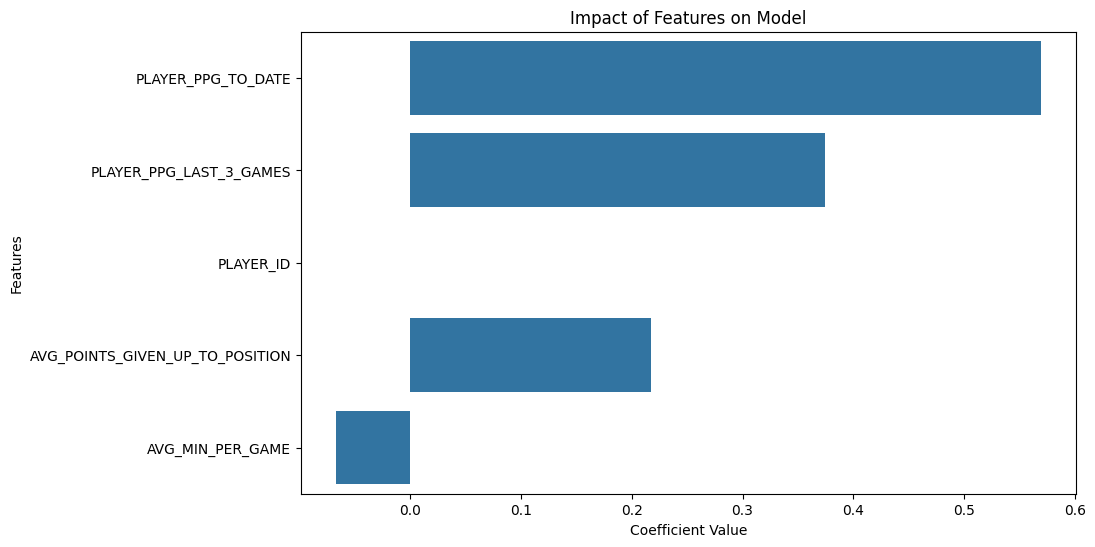

c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

Percentage of predictions within ±3 points of actual values: 49.13%
Mean Squared Error: 31.12173216175277
Root Mean Squared Error: 5.578685522751105
plotting actual vs predicted


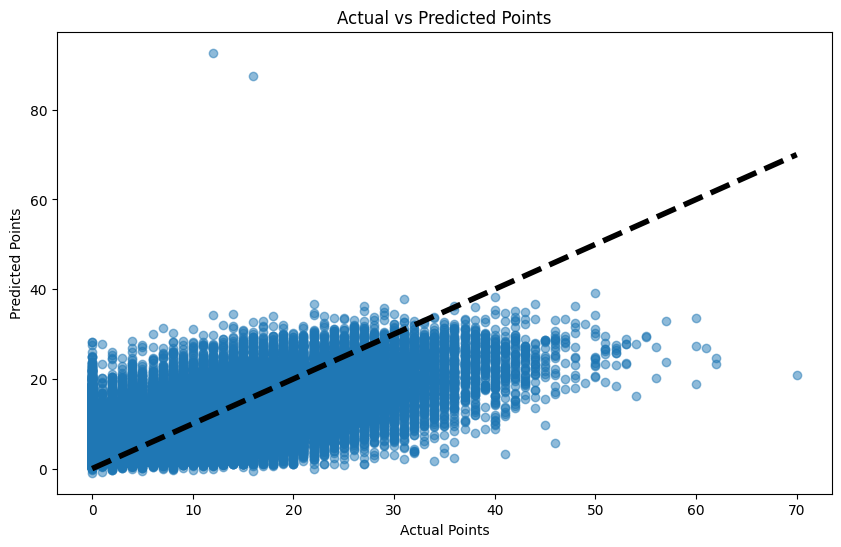

plotting residuals


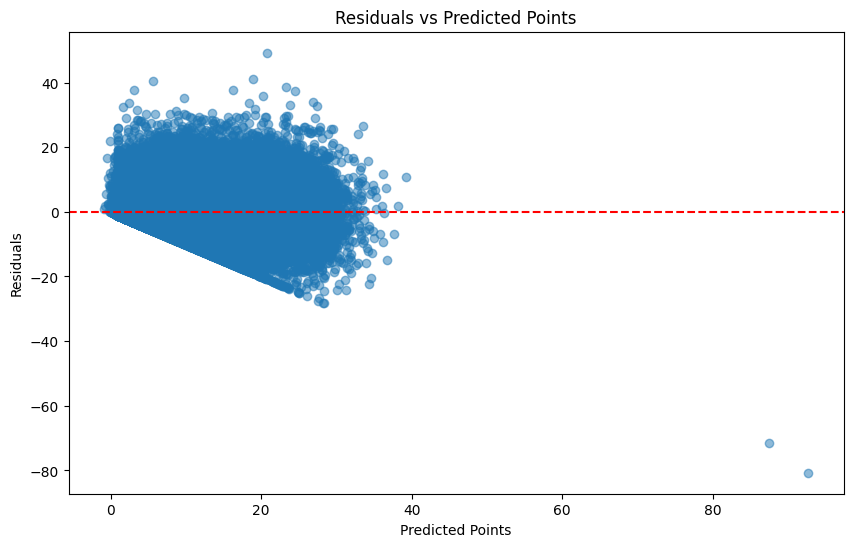

Individual Plots


c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

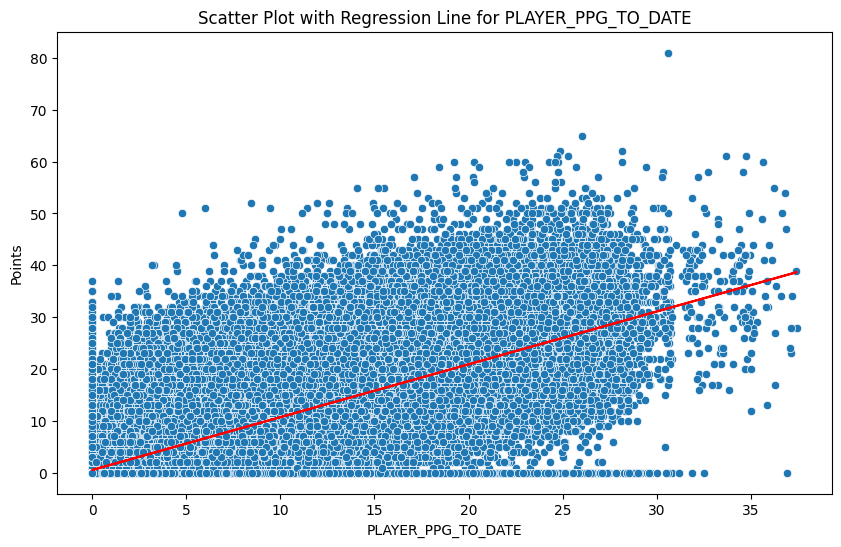

c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

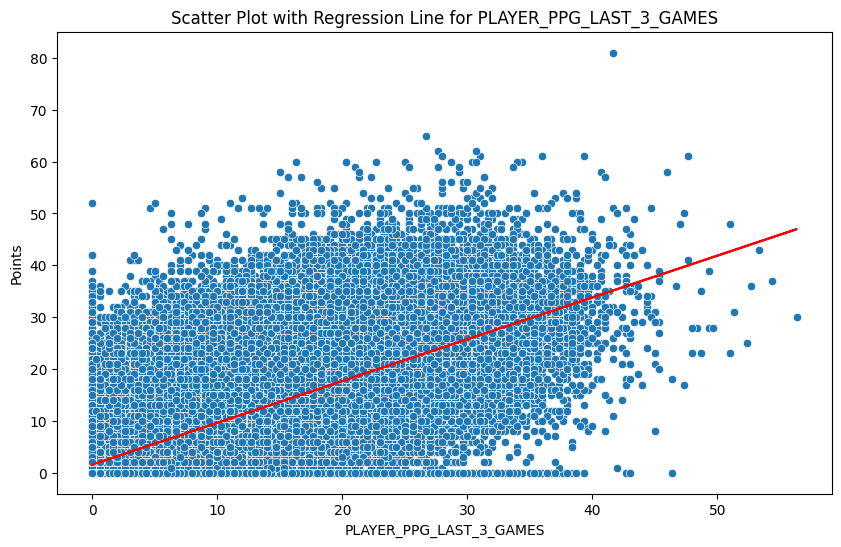

c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

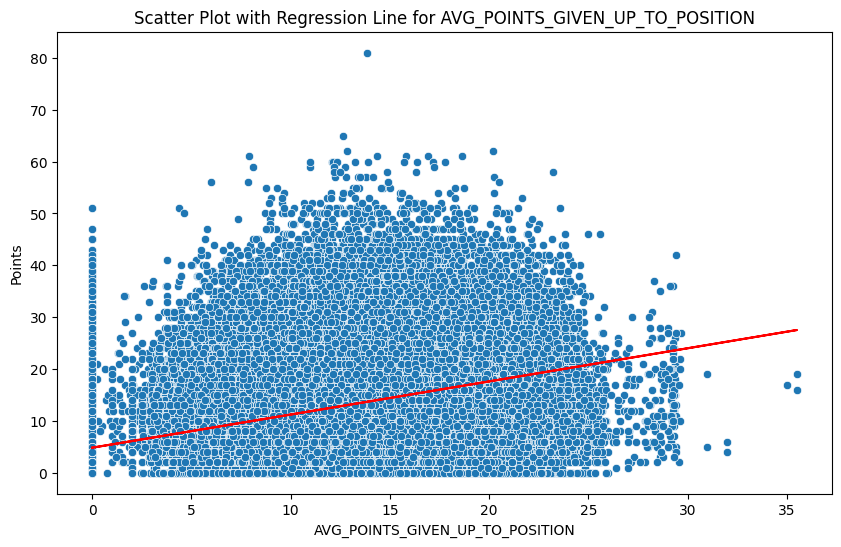

c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

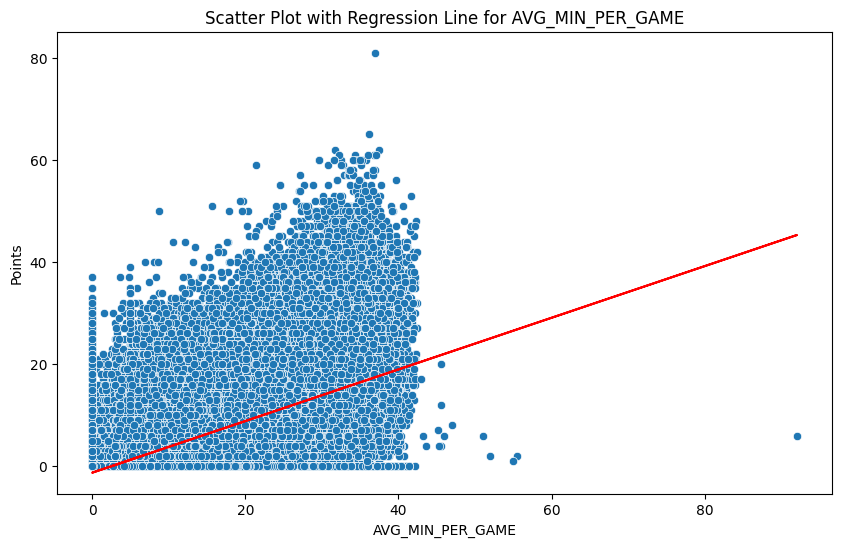

In [8]:
def LinRegModel(final_df):
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    import joblib
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np  


    # Handle missing values in features and target
    final_df = final_df.dropna(subset=['PLAYER_PPG_TO_DATE', 'PLAYER_PPG_LAST_3_GAMES', 'PLAYER_ID', 'PTS','AVG_POINTS_GIVEN_UP_TO_POSITION','AVG_MIN_PER_GAME'])

    # Define features and target
    X = final_df[['PLAYER_PPG_TO_DATE', 'PLAYER_PPG_LAST_3_GAMES', 'PLAYER_ID','AVG_POINTS_GIVEN_UP_TO_POSITION','AVG_MIN_PER_GAME']]
    y = final_df['PTS']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    feature_coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])

    # Plotting Coefficients
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_coefficients.Coefficient, y=feature_coefficients.index)
    plt.xlabel('Coefficient Value')
    plt.ylabel('Features')
    plt.title('Impact of Features on Model')
    plt.show()

    joblib.dump(model, 'points_prediction_model.joblib')


    # Predict on the test set
    predictions = model.predict(X_test)

    absolute_diff = np.abs(y_test - predictions)

    # Calculate the percentage of predictions within ±2 points of the actual values
    within_2_points = np.mean(absolute_diff <= 2) * 100  # Percentage calculation

    print(f"Percentage of predictions within ±2 points of actual values: {within_2_points:.2f}%")

    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    rmse = mse ** 0.5

    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")

    print("plotting actual vs predicted")
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.xlabel('Actual Points')
    plt.ylabel('Predicted Points')
    plt.title('Actual vs Predicted Points')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.show()

    print("plotting residuals")
    residuals = y_test - predictions

    # Plotting the Residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(predictions, residuals, alpha=0.5)
    plt.xlabel('Predicted Points')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted Points')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()
    

    print("Individual Plots")
    for feature in ['PLAYER_PPG_TO_DATE', 'PLAYER_PPG_LAST_3_GAMES', 'AVG_POINTS_GIVEN_UP_TO_POSITION', 'AVG_MIN_PER_GAME']:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=X_train[feature], y=y_train)
        
        # Fit a simple linear regression model
        simple_reg_model = LinearRegression()
        simple_reg_model.fit(X_train[[feature]], y_train)
        y_pred = simple_reg_model.predict(X_train[[feature]])

        # Plot the regression line
        plt.plot(X_train[feature], y_pred, color='red')
        plt.xlabel(feature)
        plt.ylabel('Points')
        plt.title(f'Scatter Plot with Regression Line for {feature}')
        plt.show()
    return model

df = pd.read_csv("NBA.csv")

LinearReg = LinRegModel(df)


## K Nearest Neighbors

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

def KNNModelWithGridSearch(final_df):
    final_df = final_df.dropna(subset=['PLAYER_PPG_TO_DATE', 'PLAYER_PPG_LAST_3_GAMES', 'PTS', 'AVG_POINTS_GIVEN_UP_TO_POSITION'])
    
    # Normalize the feature data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(final_df[['PLAYER_PPG_TO_DATE', 'PLAYER_PPG_LAST_3_GAMES', 'AVG_POINTS_GIVEN_UP_TO_POSITION']])

    # Define features and target
    X = scaled_features
    y = final_df['PTS']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    knn_model = KNeighborsRegressor()
    param_grid = {'n_neighbors': [200, 400]}  

    # Grid Search with cross-validation
    grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Best parameters and model
    print("Best parameters:", grid_search.best_params_)
    best_model = grid_search.best_estimator_

    # Predictions with the best model
    predictions = best_model.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, predictions)
    rmse = mse ** 0.5
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")

    # Actual vs Predicted Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.xlabel('Actual Points')
    plt.ylabel('Predicted Points')
    plt.title('Actual vs Predicted Points')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.show()

    # Residuals Plot
    residuals = y_test - predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(predictions, residuals, alpha=0.5)
    plt.xlabel('Predicted Points')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted Points')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()
    return best_model

df = pd.read_csv("NBA.csv")
KNNModel = KNNModelWithGridSearch(df)


c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning:

KeyboardInterrupt: 

## XGBoost Implementation

c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning:

Model Mean Squared Error: 30.674466127893997
Model Root Mean Squared Error: 5.538453405770784


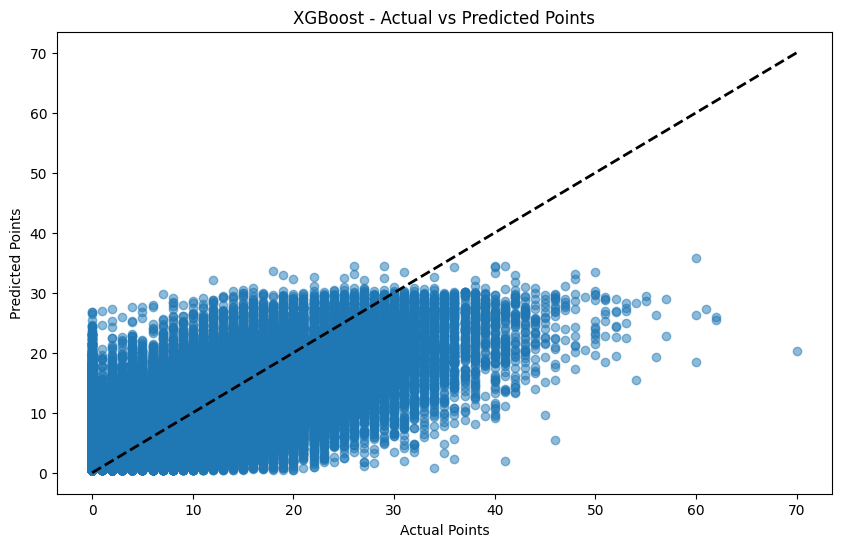

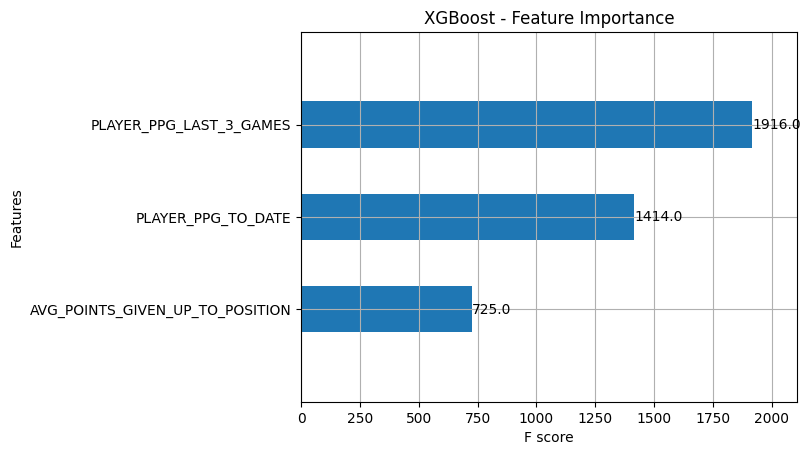

In [5]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

def XGBoostModel(final_df):
    # Define the feature names
    feature_names = ['PLAYER_PPG_TO_DATE', 'PLAYER_PPG_LAST_3_GAMES', 'AVG_POINTS_GIVEN_UP_TO_POSITION']

    final_df = final_df.dropna(subset=feature_names + ['PTS'])
    
    # Normalize the feature data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(final_df[feature_names])

    # Create a DataFrame with the scaled features
    X = pd.DataFrame(scaled_features, columns=feature_names)
    y = final_df['PTS']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the XGBoost regressor with the specified parameters
    xg_reg = xgb.XGBRegressor(
        objective='reg:squarederror',
        colsample_bytree=0.5,
        learning_rate=0.1,
        max_depth=5,
        alpha=15,
        n_estimators=200
    )

    # Train the model
    xg_reg.fit(X_train, y_train, eval_metric="rmse")

    # Predictions with the model
    predictions = xg_reg.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    rmse = mse ** 0.5
    print(f"Model Mean Squared Error: {mse}")
    print(f"Model Root Mean Squared Error: {rmse}")

    # Visualization 1: Actual vs Predicted Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.xlabel('Actual Points')
    plt.ylabel('Predicted Points')
    plt.title('XGBoost - Actual vs Predicted Points')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.show()

    # Visualization 2: Feature Importance Plot
    xgb.plot_importance(xg_reg, height=0.5)
    plt.title("XGBoost - Feature Importance")
    plt.show()

    return xg_reg

# Load data and run the function
df = pd.read_csv("NBA.csv")
XGBoostModel = XGBoostModel(df)




## NBA Live Stats

In [9]:
## Functions for live nba_api usage

from nba_api.stats.static import players, teams
from nba_api.stats.endpoints import playergamelog, leaguegamefinder, leaguedashplayerstats
from nba_api.stats.endpoints import PlayerGameLog, teamgamelog
import pandas as pd
from datetime import datetime, timedelta

def get_top_players_by_minutes(season, num_players=50):
    """ Retrieves the top 50 players of the season based on minutes played. """
    player_stats = leaguedashplayerstats.LeagueDashPlayerStats().get_data_frames()[0]
    top_players = player_stats.sort_values(by='MIN', ascending=False).head(num_players)
    return top_players[['PLAYER_ID', 'PLAYER_NAME']]

def get_player_game_logs(player_id, season):
    """ Retrieves the game logs for a specific player in a season. """
    return playergamelog.PlayerGameLog(player_id=player_id, season = season).get_data_frames()[0]


def parse_game_date(game_date):
    """ Convert game date from 'MMM DD, YYYY' to 'YYYY-MM-DD' format. """
    return datetime.strptime(game_date, "%b %d, %Y").strftime("%Y-%m-%d")


def calculate_ppg_last_3_games(player_id, season, season_type):
    """ Calculates the average points per game (PPG) for the last 3 games played by a player. """
    print("Player ID:", player_id, "Season:", season)

    # Fetch the game logs for the player
    game_logs = playergamelog.PlayerGameLog(player_id=player_id, 
                                            season_type_all_star=season_type, 
                                            season=season).get_data_frames()[0]

    # Sort the game logs by date and take the last 3 games
    game_logs['GAME_DATE'] = pd.to_datetime(game_logs['GAME_DATE'])
    last_3_games = game_logs.sort_values(by='GAME_DATE', ascending=False).head(3)

    # Calculate and return PPG for the last 3 games
    return last_3_games['PTS'].mean() if not last_3_games.empty else 0



def get_team_id_by_abbreviation(abbreviation):
    """ Get team ID by team abbreviation. """
    team_info = teams.find_team_by_abbreviation(abbreviation)
    return team_info['id'] if team_info else None

def get_opponent_ppg(opponent_abbreviation, game_date, season):
    opponent_team_id = get_team_id_by_abbreviation(opponent_abbreviation)
    if opponent_team_id:
        # Format the date for the API request
        end_date = datetime.strptime(game_date, "%Y-%m-%d").strftime("%m/%d/%Y")

        
        print(opponent_abbreviation)
        game_finder = teamgamelog.TeamGameLog(
            team_id = opponent_team_id,
            season = season,
            season_type_all_star="Regular Season",
            date_to_nullable=end_date
        )

        games = game_finder.get_data_frames()[0]
        return games['PTS'].mean() if not games.empty else 0
    else:
        return 0
    


import pandas as pd
import numpy as np
from nba_api.stats.static import players, teams
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.live.nba.endpoints import boxscore

def predict_next_game_points(player_name, player_position):
    season = "2023-24"
    season_type = 'Regular Season'

    # Get player ID
    player_info = players.find_players_by_full_name(player_name)
    if not player_info:
        return f"No player found with name {player_name}"
    player_id = player_info[0]['id']

    # Get player game logs
    game_logs = get_player_game_logs(player_id, season)
    if game_logs.empty:
        return f"No game logs found for {player_name} in season {season}"

    # Sort game_logs by 'GAME_DATE' and get the last game
    game_logs['GAME_DATE'] = pd.to_datetime(game_logs['GAME_DATE'])
    game_logs = game_logs.sort_values(by='GAME_DATE', ascending=True)
    last_game = game_logs.iloc[-1]

    # Calculate required inputs for the model
    season_ppg = game_logs['PTS'].mean()
    game_date = last_game['GAME_DATE'].strftime("%Y-%m-%d")
    ppg_last_3_games = calculate_ppg_last_3_games(player_id, season, season_type)
    avg_minutes_per_game = game_logs['MIN'].mean()
    opponent_abbreviation = last_game['MATCHUP'].split(' ')[-1]

    # Get opponent PPG by position
    opponent_ppg = get_opponent_ppg_to_position(opponent_abbreviation, game_date, season, player_position)

    # Prepare input features and predict
    print(season_ppg, ppg_last_3_games, opponent_ppg, avg_minutes_per_game)
    input_features = np.array([[season_ppg, ppg_last_3_games, player_id, opponent_ppg, avg_minutes_per_game]])
    predicted_points = LinearReg.predict(input_features)[0]
    return predicted_points

def get_opponent_ppg_to_position(opponent_abbreviation, game_date, season, player_position):
    nba_teams = teams.get_teams()
    opp = [team for team in nba_teams if team['abbreviation'] == opponent_abbreviation][0]
    opp_id = opp['id']

    gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=opp_id)
    games = gamefinder.get_data_frames()[0]
    games['GAME_DATE'] = pd.to_datetime(games['GAME_DATE'])
    season_start = pd.Timestamp(year=2023, month=10, day=1)
    games = games[games['GAME_DATE'] >= season_start]

    game_data = {}
    player_data = []
    position_mapping = {'PG': 'G', 'SG': 'G', 'SF': 'F', 'PF': 'F', 'C': 'C'}

    for index, row in games.iterrows():
        game_id = row['GAME_ID']
        box = boxscore.BoxScore(game_id)
        team_to_process = 'home_team' if box.home_team.get_dict()['teamTricode'] != opponent_abbreviation else 'away_team'

        players = getattr(box, team_to_process).get_dict()['players']
        for player in players:
            if player['starter'] == '1':
                simplified_position = position_mapping.get(player['position'], player['position'])
                player_info = {
                    'player_id': player['personId'],
                    'points': player['statistics']['points'],
                    'position': simplified_position
                }
                player_data.append(player_info)

    df_player_data = pd.DataFrame(player_data)
    avg_points_by_position = df_player_data.groupby('position')['points'].mean()
    return avg_points_by_position.get(player_position, np.nan)

# Use the Model for prediction
player_name = "Al Horford"
player_position = 'C'
predicted_points = predict_next_game_points(player_name, player_position)
print(f"Predicted Points for {player_name}'s next game: {predicted_points}")

C:\Users\handj\AppData\Local\Temp\ipykernel_69040\2088546346.py:92: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_logs['GAME_DATE'] = pd.to_datetime(game_logs['GAME_DATE'])
C:\Users\handj\AppData\Local\Temp\ipykernel_69040\2088546346.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_logs['GAME_DATE'] = pd.to_datetime(game_logs['GAME_DATE'])


Player ID: 201143 Season: 2023-24
7.4 6.0 13.178571428571429 26.35
Predicted Points for Al Horford's next game: 8.50923215797178


c:\Users\handj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
